# Tutorial on self-normalizing networks on the MNIST data set: multi-layer perceptrons

*Author:* Kajetan Schweighofer, 2021

In [1]:
import os
import copy
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# load data and preprocess

path = os.path.join(".", "dataset", "mnist")
os.makedirs(path, exist_ok=True)

# convert PIL image to tensor and normalize
transform = transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train = torchvision.datasets.MNIST(path, download=True, train=True, transform=transform)
test = torchvision.datasets.MNIST(path, download=True, train=False, transform=transform)

## Functions

### Model

In [3]:

    
class ExpActivation(nn.Module):
    """
    Applies elementwise activation based on exponential function

    Inspired by squared relu, but with bounded range and gradient for better stability
    """
    def __init__(self):
        super(ExpActivation, self).__init__()

    def forward(self, input):
        # print("using exponential activation")
        return torch.exp(input)

class ReEUActivation(nn.Module):
    """
    Applies elementwise activation based on rectified exponential unit function
    f(x) = exp(x) if x > 0 else 0
    """
    def __init__(self):
        super(ReEUActivation, self).__init__()

    def forward(self, input):
        return torch.exp(nn.functional.relu(input)) - 1.0
    
    
class SoftmaxActivation(nn.Module):
    """
    Applies the Softmax activation function elementwise
    """
    def __init__(self):
        super(SoftmaxActivation, self).__init__()

    def forward(self, input):
        return nn.functional.softmax(input, dim=-1)
    
    

In [4]:
class MLP(nn.Module):

    def __init__(self, in_features: int, out_features: int, p_drop=0.2, act_fn: str="relu"):
        super(MLP, self).__init__()

        if act_fn == "selu":
            activation = nn.SELU()
        elif act_fn == "relu":
            activation = nn.ReLU()
        elif act_fn == "exp":
            activation = ExpActivation()
        elif act_fn == "softmax":
            activation = SoftmaxActivation()
        elif act_fn == "reu":
            activation = ReEUActivation()
        elif act_fn == "elu":
            activation = nn.ELU()
        else:
            raise ValueError(f"Unsupported activation function: {act_fn}")
        # activation = nn.SELU() if act_fn == "selu" else nn.ReLU()
        # dropout = nn.AlphaDropout(p=p_drop) if act_fn == "selu" else nn.Dropout(p=p_drop) # use standard dropout for all activations
        dropout = nn.Dropout(p=p_drop)
        self.net = nn.Sequential(
            nn.Flatten(),   # flatten input image from batchx1x28x28 to batchx784
            nn.Linear(in_features=in_features, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=256),
            activation,
            dropout,
            nn.Linear(in_features=256, out_features=out_features)
        )

        if act_fn == "selu":
            for param in self.net.parameters():
                # biases zero
                if len(param.shape) == 1:
                    nn.init.constant_(param, 0)
                # others using lecun-normal initialization
                else:
                    nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='linear')

    def forward(self, x):
        return self.net(x)

In [42]:
class LN_MLP(nn.Module):

    def __init__(self, in_features: int, out_features: int, p_drop=0.2, act_fn: str="relu"):
        super(LN_MLP, self).__init__()

        if act_fn == "selu":
            activation = nn.SELU()
        elif act_fn == "relu":
            activation = nn.ReLU()
        elif act_fn == "exp":
            activation = ExpActivation()
        elif act_fn == "softmax":
            activation = SoftmaxActivation()
        elif act_fn == "reu":
            activation = ReEUActivation()
        elif act_fn == "elu":
            activation = nn.ELU()
        else:
            raise ValueError(f"Unsupported activation function: {act_fn}")
        # activation = nn.SELU() if act_fn == "selu" else nn.ReLU()
        # dropout = nn.AlphaDropout(p=p_drop) if act_fn == "selu" else nn.Dropout(p=p_drop) # use standard dropout for all activations
        dropout = nn.Dropout(p=p_drop)
        self.net = nn.Sequential(
            nn.Flatten(),   # flatten input image from batchx1x28x28 to batchx784
            nn.Linear(in_features=in_features, out_features=512),
            # nn.RMSNorm(512),
            nn.LayerNorm(512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=512),
            nn.LayerNorm(512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=512),
            nn.LayerNorm(512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=256),
            nn.LayerNorm(256),
            activation,
            dropout,
            nn.Linear(in_features=256, out_features=out_features)
        )

        if act_fn == "selu":
            for param in self.net.parameters():
                # biases zero
                if len(param.shape) == 1:
                    nn.init.constant_(param, 0)
                # others using lecun-normal initialization
                else:
                    nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='linear')

    def forward(self, x):
        return self.net(x)

### Accuracy metric

In [43]:
class Accuracy(nn.Module):

    def forward(self, x, y):

        y_pred = F.softmax(x, dim=1).argmax(dim=1).cpu().numpy()
        y = y.cpu().numpy()

        return accuracy_score(y_true=y, y_pred=y_pred)

### Training / Evaluation methods

In [44]:
def _forward(network: nn.Module, data: DataLoader, metric: callable):

    for x, y in data:
        x = x.to(next(network.parameters()).device)

        # y_hat = network.forward(x)
        y_hat = network.forward(x).cpu()
        loss = metric(y_hat, y)
        yield loss

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: torch.optim.Optimizer) -> list:

    network.train()

    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        opt.zero_grad()
        try:
            err.backward()
            opt.step()
        except:
            print('error in update step')
    return errs

@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> float:

    network.eval()

    performance = []
    for p in _forward(network, data, metric):
        p = np.array(p)
        performance.append(p.item())
    return np.mean(performance).item()


def fit(network: nn.Module, trainloader: DataLoader, valloader: DataLoader,
          testloader: DataLoader, epochs: int, lr: float):
    optimizer = torch.optim.SGD(params=network.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    accuracy = Accuracy()

    train_losses, val_losses, accuracies = [], [], []

    # performance before training
    val_losses.append(evaluate(network=network, data=valloader, metric=ce))

    pbar = tqdm(range(epochs))
    for ep in pbar:
        # update network
        tl = update(network=network, data=trainloader, loss=ce, opt=optimizer)
        train_losses.extend(tl)
        vl = evaluate(network=network, data=valloader, metric=ce)
        val_losses.append(vl)
        ac = evaluate(network=network, data=valloader, metric=accuracy)

        if len(accuracies) == 0 or ac > max(accuracies):
            # here we would store the model on disc for early stopping
            best_model = copy.deepcopy(network)

        accuracies.append(ac)

        print(f"train loss: {round(np.mean(tl), 4):.4f}, "
              f"val loss: {round(vl, 4):.4f}, "
              f"accuracy: {round(ac * 100, 2):.2f}%")

        pbar.set_description_str(desc=f"Epoch {ep+1}")

    # evaluate on best model obtained throughout training
    acc = evaluate(network=best_model, data=testloader, metric=accuracy)

    print(f"Final accuracy on testset: {round(acc*100, 2):.2f}%")

    return train_losses, val_losses, accuracies, acc

## Training

### Hyperparameters

In [45]:
epochs = 20
lr = 1e-3
batch_size = 128
num_workers = 4
p_drop = 0.05

### Create Dataloaders

In [46]:
# obtain validation set (1/6 of train data to be equal to size of test data)
rng = np.random.default_rng(seed=42)
val_inds = rng.choice(np.arange(len(train)), size=len(train)//6, replace=False)
train_inds = np.delete(np.arange(len(train)), val_inds)

trainloader = DataLoader(Subset(train, indices=train_inds),
                         batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
valloader = DataLoader(Subset(train, indices=val_inds),
                       batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
testloader = DataLoader(test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)

### Train Networks

In [47]:
# ReLU training

# 28x28 = 784 input images for 10 classes
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="relu").to(device)
network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="relu").to(device)
rtl, rvl, raccs, racc = fit(network, trainloader, valloader, testloader, epochs, lr)

/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 1:   5%|▌         | 1/20 [00:01<00:31,  1.65s/it]

train loss: 1.5394, val loss: 0.8696, accuracy: 82.20%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 2:  10%|█         | 2/20 [00:03<00:29,  1.65s/it]

train loss: 0.7624, val loss: 0.5313, accuracy: 87.77%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 3:  15%|█▌        | 3/20 [00:04<00:27,  1.62s/it]

train loss: 0.5276, val loss: 0.4046, accuracy: 89.72%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 4:  20%|██        | 4/20 [00:06<00:25,  1.59s/it]

train loss: 0.4242, val loss: 0.3399, accuracy: 90.71%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 5:  25%|██▌       | 5/20 [00:07<00:23,  1.58s/it]

train loss: 0.3616, val loss: 0.2992, accuracy: 91.34%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 6:  30%|███       | 6/20 [00:09<00:22,  1.59s/it]

train loss: 0.3206, val loss: 0.2700, accuracy: 92.08%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 7:  35%|███▌      | 7/20 [00:11<00:20,  1.58s/it]

train loss: 0.2896, val loss: 0.2491, accuracy: 92.58%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 8:  40%|████      | 8/20 [00:12<00:18,  1.58s/it]

train loss: 0.2678, val loss: 0.2328, accuracy: 93.09%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 9:  45%|████▌     | 9/20 [00:14<00:17,  1.59s/it]

train loss: 0.2481, val loss: 0.2199, accuracy: 93.42%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 10:  50%|█████     | 10/20 [00:15<00:15,  1.59s/it]

train loss: 0.2322, val loss: 0.2063, accuracy: 93.85%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 11:  55%|█████▌    | 11/20 [00:17<00:14,  1.60s/it]

train loss: 0.2178, val loss: 0.1963, accuracy: 94.14%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 12:  60%|██████    | 12/20 [00:19<00:12,  1.59s/it]

train loss: 0.2069, val loss: 0.1881, accuracy: 94.33%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 13:  65%|██████▌   | 13/20 [00:20<00:11,  1.61s/it]

train loss: 0.1962, val loss: 0.1798, accuracy: 94.60%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 14:  70%|███████   | 14/20 [00:22<00:09,  1.62s/it]

train loss: 0.1864, val loss: 0.1736, accuracy: 94.85%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 15:  75%|███████▌  | 15/20 [00:23<00:08,  1.60s/it]

train loss: 0.1780, val loss: 0.1674, accuracy: 95.00%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 16:  80%|████████  | 16/20 [00:25<00:06,  1.61s/it]

train loss: 0.1715, val loss: 0.1620, accuracy: 95.24%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 17:  85%|████████▌ | 17/20 [00:27<00:04,  1.62s/it]

train loss: 0.1641, val loss: 0.1565, accuracy: 95.41%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 18:  90%|█████████ | 18/20 [00:28<00:03,  1.62s/it]

train loss: 0.1579, val loss: 0.1525, accuracy: 95.55%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 19:  95%|█████████▌| 19/20 [00:30<00:01,  1.62s/it]

train loss: 0.1513, val loss: 0.1478, accuracy: 95.64%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 20: 100%|██████████| 20/20 [00:32<00:00,  1.60s/it]

train loss: 0.1461, val loss: 0.1440, accuracy: 95.68%


Final accuracy on testset: 95.98%


In [48]:
# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="exp").to(device)
# softtl, softvl, softaccs, softacc = fit(network, trainloader, valloader, testloader, epochs, lr)

network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="exp").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu").to(device)

LN_tl, LN_vl, LN_accs, LN_acc = fit(network, trainloader, valloader, testloader, epochs, lr)

/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 1:   5%|▌         | 1/20 [00:01<00:30,  1.60s/it]

train loss: 0.1415, val loss: 0.1407, accuracy: 95.88%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 2:  10%|█         | 2/20 [00:03<00:29,  1.61s/it]

train loss: 0.1363, val loss: 0.1375, accuracy: 95.96%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 3:  15%|█▌        | 3/20 [00:04<00:27,  1.61s/it]

train loss: 0.1315, val loss: 0.1337, accuracy: 96.04%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 4:  20%|██        | 4/20 [00:06<00:25,  1.61s/it]

train loss: 0.1275, val loss: 0.1309, accuracy: 96.18%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 5:  25%|██▌       | 5/20 [00:08<00:24,  1.61s/it]

train loss: 0.1234, val loss: 0.1288, accuracy: 96.25%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 6:  30%|███       | 6/20 [00:09<00:22,  1.58s/it]

train loss: 0.1195, val loss: 0.1259, accuracy: 96.31%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 7:  35%|███▌      | 7/20 [00:11<00:20,  1.55s/it]

train loss: 0.1155, val loss: 0.1241, accuracy: 96.32%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 8:  40%|████      | 8/20 [00:12<00:18,  1.55s/it]

train loss: 0.1133, val loss: 0.1219, accuracy: 96.39%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 9:  45%|████▌     | 9/20 [00:14<00:17,  1.55s/it]

train loss: 0.1093, val loss: 0.1195, accuracy: 96.48%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 10:  50%|█████     | 10/20 [00:15<00:15,  1.56s/it]

train loss: 0.1070, val loss: 0.1174, accuracy: 96.54%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 11:  55%|█████▌    | 11/20 [00:17<00:13,  1.55s/it]

train loss: 0.1039, val loss: 0.1156, accuracy: 96.59%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 12:  60%|██████    | 12/20 [00:18<00:12,  1.56s/it]

train loss: 0.1001, val loss: 0.1134, accuracy: 96.63%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 13:  65%|██████▌   | 13/20 [00:20<00:11,  1.57s/it]

train loss: 0.0980, val loss: 0.1115, accuracy: 96.72%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 14:  70%|███████   | 14/20 [00:22<00:09,  1.58s/it]

train loss: 0.0955, val loss: 0.1101, accuracy: 96.76%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 15:  75%|███████▌  | 15/20 [00:23<00:07,  1.59s/it]

train loss: 0.0929, val loss: 0.1090, accuracy: 96.73%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 16:  80%|████████  | 16/20 [00:25<00:06,  1.58s/it]

train loss: 0.0907, val loss: 0.1076, accuracy: 96.83%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 17:  85%|████████▌ | 17/20 [00:26<00:04,  1.58s/it]

train loss: 0.0880, val loss: 0.1055, accuracy: 96.84%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 18:  90%|█████████ | 18/20 [00:28<00:03,  1.58s/it]

train loss: 0.0867, val loss: 0.1044, accuracy: 96.92%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 19:  95%|█████████▌| 19/20 [00:29<00:01,  1.57s/it]

train loss: 0.0843, val loss: 0.1042, accuracy: 96.89%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 20: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]

train loss: 0.0820, val loss: 0.1014, accuracy: 97.00%


Final accuracy on testset: 97.11%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 1:   5%|▌         | 1/20 [00:01<00:30,  1.59s/it]

train loss: 0.7849, val loss: 0.3431, accuracy: 89.50%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 2:  10%|█         | 2/20 [00:03<00:28,  1.58s/it]

train loss: 0.3762, val loss: 0.2534, accuracy: 92.46%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 3:  15%|█▌        | 3/20 [00:04<00:27,  1.59s/it]

train loss: 0.2931, val loss: 0.2120, accuracy: 93.59%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 4:  20%|██        | 4/20 [00:06<00:25,  1.59s/it]

train loss: 0.2484, val loss: 0.1942, accuracy: 94.26%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 5:  25%|██▌       | 5/20 [00:07<00:23,  1.58s/it]

train loss: 0.2166, val loss: 0.1744, accuracy: 94.81%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 6:  30%|███       | 6/20 [00:09<00:22,  1.59s/it]

train loss: 0.1938, val loss: 0.1617, accuracy: 95.25%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 7:  35%|███▌      | 7/20 [00:11<00:20,  1.61s/it]

train loss: 0.1817, val loss: 0.1562, accuracy: 95.38%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 8:  40%|████      | 8/20 [00:12<00:19,  1.61s/it]

train loss: 0.1653, val loss: 0.1484, accuracy: 95.72%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 9:  45%|████▌     | 9/20 [00:14<00:17,  1.60s/it]

train loss: 0.1537, val loss: 0.1395, accuracy: 96.04%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 10:  50%|█████     | 10/20 [00:15<00:15,  1.58s/it]

train loss: 0.1456, val loss: 0.1362, accuracy: 96.04%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 11:  55%|█████▌    | 11/20 [00:17<00:14,  1.58s/it]

train loss: 0.1349, val loss: 0.1295, accuracy: 96.35%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 12:  60%|██████    | 12/20 [00:19<00:12,  1.59s/it]

train loss: 0.1255, val loss: 0.1295, accuracy: 96.32%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 13:  65%|██████▌   | 13/20 [00:20<00:11,  1.59s/it]

train loss: 0.1191, val loss: 0.1288, accuracy: 96.42%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 14:  70%|███████   | 14/20 [00:22<00:09,  1.60s/it]

train loss: 0.1112, val loss: 0.1242, accuracy: 96.41%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 15:  75%|███████▌  | 15/20 [00:23<00:07,  1.60s/it]

train loss: 0.1095, val loss: 0.1205, accuracy: 96.64%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 16:  80%|████████  | 16/20 [00:25<00:06,  1.59s/it]

train loss: 0.1051, val loss: 0.1187, accuracy: 96.65%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 17:  85%|████████▌ | 17/20 [00:27<00:04,  1.57s/it]

train loss: 0.0963, val loss: 0.1180, accuracy: 96.65%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 18:  90%|█████████ | 18/20 [00:28<00:03,  1.59s/it]

train loss: 0.0949, val loss: 0.1153, accuracy: 97.00%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 19:  95%|█████████▌| 19/20 [00:30<00:01,  1.60s/it]

train loss: 0.0894, val loss: 0.1159, accuracy: 96.99%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 20: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]

train loss: 0.0847, val loss: 0.1166, accuracy: 96.90%


Final accuracy on testset: 97.00%


In [49]:
# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="softmax").to(device)
network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="elu").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu").to(device)

elutl, eluvl, eluaccs, eluacc = fit(network, trainloader, valloader, testloader, epochs, lr)


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 1:   5%|▌         | 1/20 [00:01<00:30,  1.59s/it]

train loss: 1.0810, val loss: 0.5799, accuracy: 86.05%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 2:  10%|█         | 2/20 [00:03<00:28,  1.57s/it]

train loss: 0.5342, val loss: 0.4202, accuracy: 88.98%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 3:  15%|█▌        | 3/20 [00:04<00:26,  1.58s/it]

train loss: 0.4214, val loss: 0.3562, accuracy: 90.24%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 4:  20%|██        | 4/20 [00:06<00:25,  1.60s/it]

train loss: 0.3662, val loss: 0.3192, accuracy: 91.13%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 5:  25%|██▌       | 5/20 [00:07<00:23,  1.59s/it]

train loss: 0.3316, val loss: 0.2949, accuracy: 91.75%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 6:  30%|███       | 6/20 [00:09<00:22,  1.59s/it]

train loss: 0.3062, val loss: 0.2756, accuracy: 92.20%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 7:  35%|███▌      | 7/20 [00:11<00:20,  1.59s/it]

train loss: 0.2879, val loss: 0.2609, accuracy: 92.54%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 8:  40%|████      | 8/20 [00:12<00:19,  1.60s/it]

train loss: 0.2716, val loss: 0.2475, accuracy: 92.94%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 9:  45%|████▌     | 9/20 [00:14<00:17,  1.58s/it]

train loss: 0.2568, val loss: 0.2381, accuracy: 93.09%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 10:  50%|█████     | 10/20 [00:15<00:16,  1.60s/it]

train loss: 0.2452, val loss: 0.2277, accuracy: 93.47%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 11:  55%|█████▌    | 11/20 [00:17<00:14,  1.60s/it]

train loss: 0.2340, val loss: 0.2189, accuracy: 93.64%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 12:  60%|██████    | 12/20 [00:19<00:12,  1.60s/it]

train loss: 0.2255, val loss: 0.2115, accuracy: 93.88%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 13:  65%|██████▌   | 13/20 [00:20<00:11,  1.59s/it]

train loss: 0.2162, val loss: 0.2039, accuracy: 94.09%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 14:  70%|███████   | 14/20 [00:22<00:09,  1.58s/it]

train loss: 0.2074, val loss: 0.1978, accuracy: 94.26%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 15:  75%|███████▌  | 15/20 [00:23<00:07,  1.59s/it]

train loss: 0.2007, val loss: 0.1914, accuracy: 94.43%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 16:  80%|████████  | 16/20 [00:25<00:06,  1.58s/it]

train loss: 0.1943, val loss: 0.1858, accuracy: 94.53%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 17:  85%|████████▌ | 17/20 [00:26<00:04,  1.57s/it]

train loss: 0.1880, val loss: 0.1799, accuracy: 94.70%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 18:  90%|█████████ | 18/20 [00:28<00:03,  1.59s/it]

train loss: 0.1809, val loss: 0.1755, accuracy: 94.88%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 19:  95%|█████████▌| 19/20 [00:30<00:01,  1.59s/it]

train loss: 0.1766, val loss: 0.1704, accuracy: 94.94%


/tmp/ipykernel_380528/1953005661.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p = np.array(p)
Epoch 20: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]

train loss: 0.1708, val loss: 0.1666, accuracy: 95.02%


Final accuracy on testset: 95.34%


In [50]:

# SELU training
# network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="selu").to(device)
# stl, svl, saccs, sacc = fit(network, trainloader, valloader, testloader, epochs, lr)

### Plot results

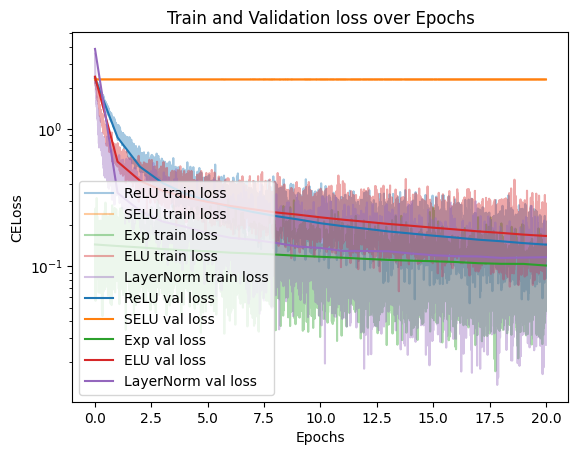

In [53]:
plt.figure()
plt.plot(np.asarray(range(len(rtl))) / len(trainloader), rtl, alpha=0.4, label="ReLU train loss")
plt.plot(np.asarray(range(len(stl))) / len(trainloader), stl, alpha=0.4, label="SELU train loss")
plt.plot(np.asarray(range(len(softtl))) / len(trainloader), softtl, alpha=0.4, label="Exp train loss")
plt.plot(np.asarray(range(len(elutl))) / len(trainloader), elutl, alpha=0.4, label="ELU train loss")
plt.plot(np.asarray(range(len(LN_tl))) / len(trainloader), LN_tl, alpha=0.4, label="LayerNorm train loss")
plt.plot(range(len(rvl)), rvl, color="C0", label="ReLU val loss")
plt.plot(range(len(svl)), svl, color="C1", label="SELU val loss")
plt.plot(range(len(softvl)), softvl, color="C2", label="Exp val loss")
plt.plot(range(len(eluvl)), eluvl, color="C3", label="ELU val loss")
plt.plot(range(len(LN_vl)), LN_vl, color="C4", label="LayerNorm val loss")
plt.title("Train and Validation loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("CELoss")
plt.yscale("log")
plt.legend()
plt.show()

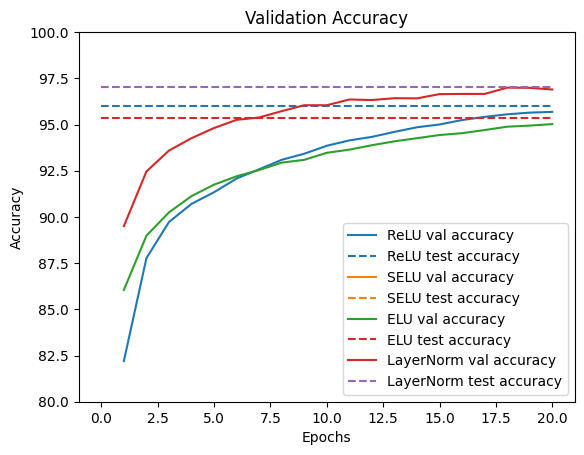

In [55]:
plt.figure()
plt.plot(range(1, len(raccs)+1), [a*100 for a in raccs], label="ReLU val accuracy")
plt.hlines(y=racc*100, xmin=0, xmax=len(raccs), colors="C0", linestyles="dashed", label="ReLU test accuracy")
plt.plot(range(1, len(saccs)+1), [a*100 for a in saccs], label="SELU val accuracy")
plt.hlines(y=sacc*100, xmin=0, xmax=len(saccs), colors="C1", linestyles="dashed", label="SELU test accuracy")
# plt.plot(range(1, len(softaccs)+1), [a*100 for a in softaccs], label="Exp val accuracy")
# plt.hlines(y=softacc*100, xmin=0, xmax=len(softaccs), colors="C2", linestyles="dashed", label="Exp test accuracy")
plt.plot(range(1, len(eluaccs)+1), [a*100 for a in eluaccs], label="ELU val accuracy")
plt.hlines(y=eluacc*100, xmin=0, xmax=len(eluaccs), colors="C3", linestyles="dashed", label="ELU test accuracy")
plt.plot(range(1, len(LN_accs)+1), [a*100 for a in LN_accs], label="LayerNorm val accuracy")
plt.hlines(y=LN_acc*100, xmin=0, xmax=len(LN_accs), colors="C4", linestyles="dashed", label="LayerNorm test accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(80, 100)
plt.legend()
plt.show()